In [1]:
%matplotlib inline

In [2]:
import os
import sys
import time

sys.path.append('/afs/crc.nd.edu/user/a/awoodard/releases/np-fit-production/CMSSW_7_4_7/python')
sys.path.append('/afs/crc.nd.edu/user/a/awoodard/.local/lib/python2.7/site-packages/')

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import matplotlib.ticker as ticker

In [3]:
from NPFitProduction.NPFitProduction.cross_sections import parse_lhe_weights, CrossSectionScan

In [4]:
outdir = '/afs/crc.nd.edu/user/a/awoodard/www/.private/ttV/reweighting_v2'
lhe = '/afs/crc.nd.edu/user/a/awoodard/releases/np-fit-production/CMSSW_7_4_7/src/NPFitProduction/NPFitProduction/test/reweight_v2/processtmp/Events/run_01/unweighted_events.lhe'
coefficients = ['cuB']

In [5]:
outdir = '/afs/crc.nd.edu/user/a/awoodard/www/.private/ttV/reweighting_v5'
lhe = '/afs/crc.nd.edu/user/a/awoodard/releases/np-fit-production/CMSSW_7_4_7/src/NPFitProduction/NPFitProduction/test/reweight_v5/processtmp/Events/run_01/unweighted_events.lhe'
coefficients = ['cuW', 'cuB', 'cH', 'tc3G', 'c3G', 'cHu', 'c2G', 'cuG']

In [6]:
indices = dict((c, i) for i, c in enumerate(coefficients))

if not os.path.isdir(outdir):
    os.makedirs(outdir)

In [7]:
scan = CrossSectionScan('/hadoop/store/user/awoodard/ttV/cross_sections/25/merged/8d.npz')

In [8]:
points, weights = parse_lhe_weights(lhe, coefficients)

parsing /afs/crc.nd.edu/user/a/awoodard/releases/np-fit-production/CMSSW_7_4_7/src/NPFitProduction/NPFitProduction/test/reweight_v5/processtmp/Events/run_01/unweighted_events.lhe

######################################################################
## PARAM_CARD AUTOMATICALY GENERATED BY MG5 FOLLOWING UFO MODEL   ####
######################################################################
##                                                                  ##
##  Width set on Auto will be computed following the information    ##
##        present in the decay.py files of the model.               ##
##        See  arXiv:1402.1178 for more details.                    ##
##                                                                  ##
######################################################################

###################################
## INFORMATION FOR MASS
###################################
Block mass 
    5 4.700000e+00 # MB 
('5', 'MB')
    6 1.720000e+02 # MT 
('6', 'MT'

In [9]:
start = time.time()
for event in range(len(weights)):
    constants, _, _, _ = np.linalg.lstsq(scan.model(points), weights[event])
print('fit {} points for {} events in {:.1} seconds'.format(len(points), len(weights), time.time() - start))

fit 227 points for 50000 events in 1e+02 seconds


In [32]:
test = [i for i in range(1, len(points)) if i % 20 == 0]
train = [i for i in range(1, len(points)) if i % 20 != 0]

errs = np.zeros((len(weights), len(points[test])))
fits = np.zeros((len(weights), len(points[test])))
start = time.time()
for event in range(len(weights)):
    constants, _, _, _ = np.linalg.lstsq(scan.model(points[train]), weights[event][train])
    fit = np.dot(scan.model(points[test]), constants)
    mg = weights[event][test]

    errs[event] = (mg - fit) / mg * 100
    fits[event] = fit

print('finished fit to {} points in {:.2f} seconds'.format(len(points[train]), time.time() - start))

finished fit to 215 points in 140.37 seconds


(50000, 11)


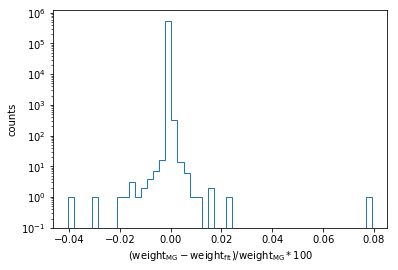

In [28]:
plt.hist(errs.ravel(), 50, histtype='step', log=True, fill=False)
plt.xlabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.ylabel('counts')

plt.savefig(os.path.join(outdir, 'errs.pdf'), bbox_inches='tight')
print(errs.shape)

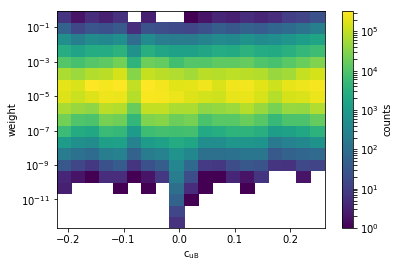

In [33]:
x = np.concatenate([points[:, indices['cuB']] for i in weights]).ravel()
y = weights.ravel()
bins = [
    np.linspace(x.min(), x.max(), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('$\mathrm{c}_\mathrm{uB}$')
plt.ylabel('weight')
plt.colorbar(label='counts')
plt.savefig(os.path.join(outdir, 'cuB_vs_weight.pdf'), bbox_inches='tight')

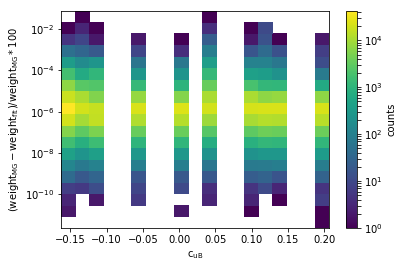

In [29]:
x = np.concatenate([points[test][:, indices['cuB']] for i in errs]).ravel()
y = np.abs(errs).ravel()

bins = [
    np.linspace(x.min(), x.max(), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())
plt.xlabel('$\mathrm{c}_\mathrm{uB}$')
plt.ylabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.colorbar(label='counts')
plt.savefig(os.path.join(outdir, 'cuB_vs_err.pdf'), bbox_inches='tight')

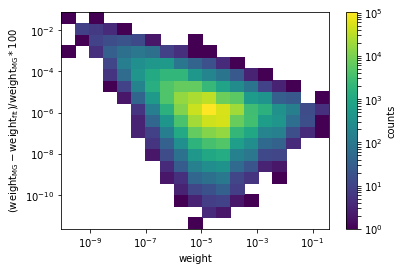

In [34]:
x = weights[:,test].ravel()
y = np.abs(errs.ravel())

bins = [
    np.logspace(np.log10(x.min()), np.log10(x.max()), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.xscale('log')
plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('weight')
plt.ylabel('$(\mathrm{weight}_{\mathrm{MG}} - \mathrm{weight}_{\mathrm{fit}}) / \mathrm{weight}_{\mathrm{MG}} * 100$')
plt.colorbar(label='counts')
plt.savefig(os.path.join(outdir, 'weight_vs_err.pdf'), bbox_inches='tight')

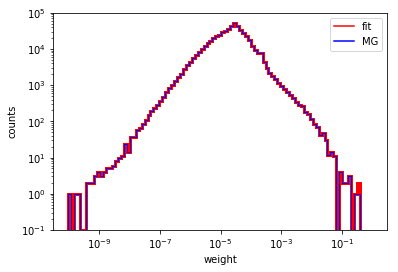

In [37]:
bins = np.logspace(np.log10(fits.min()), np.log10(fits.max()), 100)

plt.xscale('log')
plt.yscale('log')
plt.hist(fits.ravel(), bins=bins, histtype='step', fill=False, log=True, lw=3, color='red')
plt.hist(weights[:,test].ravel(), bins=bins, histtype='step', fill=False, log=True, color='blue')

fit_label, = plt.plot([0, 0], color='red')  # hack to show lines instead of boxes in the legend
mg_label, = plt.plot([0, 0], color='blue')

plt.xlabel('weight')
plt.ylabel('counts')
plt.legend([fit_label, mg_label], ['fit', 'MG'], loc='upper right')

plt.savefig(os.path.join(outdir, 'fit_and_mg.pdf'), bbox_inches='tight')


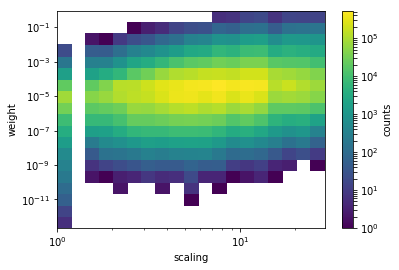

In [36]:
sm = sum(weights[:, 0])
scales = [sum(weights[:, i]) / sm for i in range(weights.shape[1])]

x = np.concatenate([scales for i in weights]).ravel()
y = weights.ravel()

bins = [
    np.logspace(np.log10(x.min()), np.log10(x.max()), 20),
    np.logspace(np.log10(y.min()), np.log10(y.max()), 20)
]

plt.xscale('log')
plt.yscale('log')
H, xedges, yedges = np.histogram2d(x, y, bins=bins)
plt.pcolormesh(xedges, yedges, H.T, norm=LogNorm())

plt.xlabel('scaling')
plt.ylabel('weight')
plt.colorbar(label='counts')
plt.savefig(os.path.join(outdir, 'weight_vs_scale.pdf'), bbox_inches='tight')